Импортируем нужные библиотеки.

In [1]:
#!python -m pip install featuretools

In [1]:
#!python -m pip install featuretools[complete]
#!python -m pip install featuretools[update_checker]
!pip install --user --upgrade catboost

Requirement already up-to-date: catboost in c:\users\user 1\appdata\roaming\python\python37\site-packages (0.22)


In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from catboost import CatBoostClassifier
#from matpotlib import plt

Распакуйте архив с данными в папку,где находится этот jupyter notebook (baseline.ipynb). У вас будет папка data,  содержащая необходимые файлы. 

Ваша задача предсказать вероятность совершения покупки Клиентом в определенных 8 категориях в следующие 7 дней, чтобы под них Банк смог направить релевантный контент (подборки). Для подготовки предсказания у вас есть данные по транзакциям 50 000 Клиентов в течение года, из которых 25 000 – в обучающей выборке и 25 000 – в тестовой. Ваша задача для тестовой выборки рассчитать для каждой из целевой категории вероятность совершения покупки в ней на следующей неделе.

Данные по транзакциям находятся в файле **transactions_train.csv**. Информация о покупках по категориям для исследуемой недели находится в файле **train_target.csv**.

Считаем данные по транзакциям и правильные ответы.

In [3]:
transactions_train=pd.read_csv('transactions_train.csv')

In [4]:
train_target=pd.read_csv('train_target.csv')

Посмотрим на данные.

In [5]:
transactions_train.head(5)

,client_dk,trans_date,amount,small_group
0,43976,0,4.563,2
1,8417,0,48.342,0
2,17309,0,12.320,0
3,33523,0,29.005,6
4,24228,0,10.266,6


* client_dk - уникальный идентификатор клиента
* trans_date - дата совершения транзакции
* amount - сумма транзакции
* small_group - категория покупки

In [6]:
train_target.head(5)

,client_dk,27,32,41,45,67,73,81,88
0,39762,1,0,0,0,0,0,0,0
1,10586,0,0,0,1,0,0,0,0
2,40115,0,1,0,0,0,0,0,0
3,34543,0,0,0,1,0,0,0,0
4,5372,0,0,0,1,0,0,0,0


* client_dk - уникальный идентификатор клиента, соответствует полю client_dk из транзакций
* числовые названия колонок - это 8 категорий продуктов. Их названия (числа) соответствуют значениям в колонке **small_group** из данных по транзакциям. Значения в этих колонках бинарные,т.е. 0 - в исследуемую неделю не было совершено покупки в данной категории, 1 - покупка была совершена. Например, клиент с номером 34110 (первая строчка) купил товар из категории 45, а по остальным категориям покупок не совершал.

Далее представлен простой вариант решения задачи. Вы можете решать соревнование используя совершенно другой подход.

Посчитаем по каждому клиенту самые простые аггрегационные признаки.

In [7]:
agg_features=transactions_train.groupby('client_dk')['amount'].agg(['mean','max','min','std','sum','count']).reset_index()

In [8]:
agg_features.head(5)

,client_dk,mean,max,min,std,sum,count
0,0,27.894672,7364.548,0.048,269.495266,21590.476,774
1,2,26.637324,1280.434,0.048,56.031283,40328.909,1514
2,3,52.988711,892.156,0.048,105.198624,49014.558,925
3,4,36.882889,1365.389,0.048,74.227945,52078.639,1412
4,7,123.575737,16678.912,0.048,674.896156,97624.832,790


Посчитаем для каждого клиента количество транзакций по каждой категории.

In [9]:
counter_df_train=transactions_train.groupby(['trans_date','small_group'])['amount'].sum()
counter_df_train2=transactions_train.groupby(['trans_date','small_group'])['amount'].count()

In [10]:
cat_sums_train=counter_df_train.reset_index().pivot(index='trans_date', \
                                                      columns='small_group',values='amount')
cat_counts_train = counter_df_train2.reset_index().pivot(index='trans_date', \
                                                      columns='small_group',values='amount')

In [11]:
cat_counts_train=cat_counts_train.fillna(0)

In [12]:
cat_counts_train.columns=['small_group_'+str(i) for i in cat_counts_train.columns]
cat_sums_train.columns=['small_group_'+str(i) for i in cat_sums_train.columns]

In [13]:
cat_counts_train.head()

,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,...,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
trans_date,,,,,,,,,,,,,,,,,,,,,
0,3365.0,362.0,3331.0,2096.0,2193.0,10990.0,8531.0,608.0,126.0,631.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2932.0,328.0,3489.0,2383.0,1852.0,12393.0,9051.0,777.0,183.0,673.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2460.0,382.0,3822.0,2270.0,1224.0,11542.0,6650.0,807.0,199.0,966.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2276.0,345.0,4026.0,2087.0,957.0,10878.0,6369.0,1603.0,168.0,929.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2398.0,407.0,3390.0,2024.0,1033.0,10687.0,5958.0,583.0,215.0,842.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
cat_sums_train.head()

,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,...,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
trans_date,,,,,,,,,,,,,,,,,,,,,
0,91906.190,9727.474,62177.923,41836.188,37278.051,357567.067,152068.110,10149.956,4044.085,164783.739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71841.038,7630.992,66420.333,48173.693,30237.599,463209.397,188236.717,12773.907,4213.261,200072.723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59376.003,16631.185,73867.041,55717.419,16124.267,526439.490,190746.835,12569.450,4427.711,314426.065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48685.496,12734.135,78478.001,55758.741,12164.580,445655.664,178044.551,23436.145,2924.433,250193.768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,54906.358,10636.131,62177.914,45982.293,18192.906,415680.450,163541.582,8647.483,3410.044,200044.950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Далее соединим все файлы в один датафрейм с таргетом.


plt.plot(cat_counts_train['small_group_4'])

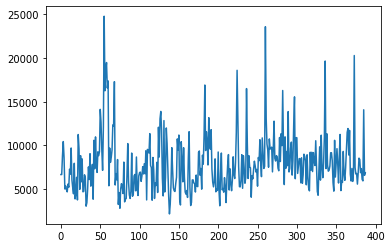

In [20]:
import matplotlib.pyplot as plt
plt.plot(cat_sums_train['small_group_60'])

In [16]:
max_ind = 0
for x in cat_counts_train.iterrows():
    print(x[0], x[1][81])

0 3.0
1 4.0
2 5.0
3 0.0
4 4.0
5 9.0
6 5.0
7 9.0
8 3.0
9 5.0
10 6.0
11 4.0
12 3.0
13 9.0
14 6.0
15 3.0
16 3.0
17 4.0
18 2.0
19 4.0
20 6.0
21 2.0
22 11.0
23 5.0
24 8.0
25 3.0
26 5.0
27 7.0
28 8.0
29 2.0
30 3.0
31 2.0
32 4.0
33 5.0
34 9.0
35 12.0
36 4.0
37 2.0
38 1.0
39 2.0
40 4.0
41 4.0
42 1.0
43 6.0
44 6.0
45 2.0
46 4.0
47 4.0
48 3.0
49 1.0
50 6.0
51 5.0
52 1.0
53 3.0
54 3.0
55 1.0
56 18.0
57 10.0
58 10.0
59 3.0
60 5.0
61 1.0
62 4.0
63 8.0
64 8.0
65 8.0
66 4.0
67 2.0
68 7.0
69 4.0
70 5.0
71 1.0
72 2.0
73 5.0
74 10.0
75 8.0
76 23.0
77 16.0
78 8.0
79 7.0
80 3.0
81 15.0
82 2.0
83 10.0
84 8.0
85 14.0
86 3.0
87 4.0
88 13.0
89 8.0
90 13.0
91 13.0
92 9.0
93 9.0
94 2.0
95 6.0
96 7.0
97 10.0
98 3.0
99 4.0
100 10.0
101 4.0
102 7.0
103 5.0
104 13.0
105 7.0
106 8.0
107 3.0
108 8.0
109 10.0
110 11.0
111 21.0
112 19.0
113 4.0
114 12.0
115 10.0
116 16.0
117 17.0
118 21.0
119 19.0
120 7.0
121 4.0
122 5.0
123 8.0
124 25.0
125 14.0
126 12.0
127 27.0
128 35.0
129 10.0
130 12.0
131 8.0
132 10.0
133 1.0
134

In [82]:
train=pd.merge(train_target,agg_features,on='client_dk')

In [83]:
train=pd.merge(train,cat_counts_train.reset_index(),on='client_dk')

In [84]:
train.head()

,client_dk,27,32,41,45,67,73,81,88,mean,...,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
0,39762,1,0,0,0,0,0,0,0,22.484556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10586,0,0,0,1,0,0,0,0,21.839333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40115,0,1,0,0,0,0,0,0,26.915832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34543,0,0,0,1,0,0,0,0,98.260840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5372,0,0,0,1,0,0,0,0,12.089445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ValueError: x and y must have same first dimension, but have shapes (25000,) and (21891979,)

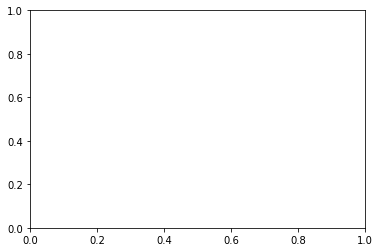

In [87]:
plt.plot(train['small_group_32'], transactions_train['trans_date'])

Теперь подгрузим тестовые данные для того, чтобы сделать предсказание. Проделаем с ними те же самые манипуляции, как и с обучающими данными.

In [57]:
transactions_test=pd.read_csv('data_final/transactions_test.csv')

Также загрузим id тестовых клиентов, по которым нужно сделать предсказание.

In [58]:
test_id=pd.read_csv('data_final/test.csv')

In [59]:
agg_features_test=transactions_test.groupby('client_dk')['amount'].agg(['mean','max','min','std','sum','count']).reset_index()

In [60]:
counter_df_test=transactions_test.groupby(['client_dk','small_group'])['amount'].count()

In [61]:
cat_counts_test=counter_df_test.reset_index().pivot(index='client_dk', \
                                                      columns='small_group',values='amount')

In [62]:
cat_counts_test=cat_counts_test.fillna(0)

In [63]:
cat_counts_test.columns=['small_group_'+str(i) for i in cat_counts_test.columns]

In [64]:
cat_counts_test.head()

,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,...,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
client_dk,,,,,,,,,,,,,,,,,,,,,
1,13.0,0.0,314.0,3.0,164.0,194.0,182.0,20.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,27.0,0.0,56.0,28.0,13.0,32.0,32.0,276.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,23.0,31.0,84.0,2.0,14.0,168.0,38.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3.0,0.0,18.0,10.0,14.0,54.0,27.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,16.0,0.0,13.0,8.0,5.0,111.0,30.0,0.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
test=pd.merge(test_id[['client_dk']],agg_features_test,on='client_dk')

In [66]:
test=pd.merge(test,cat_counts_test.reset_index(),on='client_dk')

In [67]:
common_features=list(set(train.columns).intersection(set(test.columns)))

In [68]:
X_train=train[common_features]
X_test=test[common_features]

KeyError: 'trans_date'

В этом бэйзлайне мы будем использовать простой подход - предсказывать покупки в каждой категории независимо. То есть в цикле модель обучается на отдельную категорию как на зависимую переменную, и пытается предсказать наличие покупки в этой определенной категории для теста. В итоге у нас получается 8 задач бинарной классификации.

**Важно**: Такой подход не претендует на звание лучшего, вы вольны придумать свой алгоритм решения, который, вполне вероятно, окажется лучше.

In [119]:
params = {
    'n_estimators': 1000,
    'depth': 6,
    'random_state':42,
    'learning_rate': 0.027,
    'eval_metric': 'AUC',
    'loss_function': 'MultiClass',
    'verbose': 1000
    
}

In [120]:
#В словарь будем записывать предсказания модели
results_tree = {}
main_result = [] 
#Цикл со второго элемента, потому что первой колонкой идет идентификатор клиента 
for q in train_target.columns[1:]:
    print('train product '+str(q))
    curr_target_train = train_target.loc[:,q]
    model = CatBoostClassifier(**params)
    #model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train.fillna(0).values,curr_target_train.values)
    main_result.append(model.get_evals_result())
    #Сделаем предсказание
    pred = model.predict_proba(X_test.fillna(0).values)[:,1]
    results_tree[q] = pred

train product 27
0:	total: 26.9ms	remaining: 4m 28s
1000:	total: 25.8s	remaining: 3m 52s
2000:	total: 51.5s	remaining: 3m 25s
3000:	total: 1m 16s	remaining: 2m 59s
4000:	total: 1m 41s	remaining: 2m 31s
5000:	total: 2m 6s	remaining: 2m 6s
6000:	total: 2m 33s	remaining: 1m 42s
7000:	total: 2m 59s	remaining: 1m 17s
8000:	total: 3m 26s	remaining: 51.7s
9000:	total: 3m 54s	remaining: 26s
9999:	total: 4m 21s	remaining: 0us
train product 32
0:	total: 30.7ms	remaining: 5m 6s
1000:	total: 26.1s	remaining: 3m 54s
2000:	total: 53.3s	remaining: 3m 32s
3000:	total: 1m 19s	remaining: 3m 5s
4000:	total: 1m 46s	remaining: 2m 39s
5000:	total: 2m 13s	remaining: 2m 13s
6000:	total: 2m 40s	remaining: 1m 46s
7000:	total: 3m 7s	remaining: 1m 20s
8000:	total: 3m 34s	remaining: 53.7s
9000:	total: 4m 1s	remaining: 26.8s
9999:	total: 4m 28s	remaining: 0us
train product 41
0:	total: 29.9ms	remaining: 4m 58s
1000:	total: 26.6s	remaining: 3m 58s
2000:	total: 52.6s	remaining: 3m 30s
3000:	total: 1m 18s	remaining: 3

Такое решение дает на публичном лидерборде качество 0.6023

### Подготовим файл для отправки в систему

In [121]:
submission = pd.DataFrame(data=np.zeros((25000,8)),columns=train_target.columns[1:],index=test_id['client_dk'].values)

In [122]:
for q in results_tree:
    submission[q] = results_tree[q]
submission.columns = ['cat_27','cat_32','cat_41','cat_45','cat_67','cat_73','cat_81','cat_88']

In [123]:
submission.index.name = 'client_dk'

Сохраняем прогноз на диск в папку submissions. Имя прогноза соответсвует дате и времени его создания, закодированными с помощью timestamp.

In [124]:
import time
import os

current_timestamp = int(time.time())
submission_path = 'submissions/{}.csv'.format(current_timestamp)

if not os.path.exists('submissions'):
    os.makedirs('submissions')

print(submission_path)
submission.to_csv(submission_path, index=True)

submissions/1583419622.csv


Теперь все готово! Можно отправлять решение.

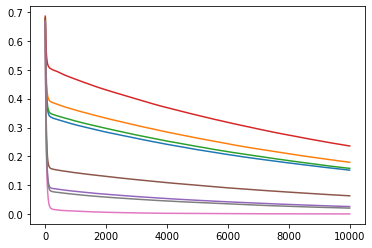

In [125]:
import matplotlib.pyplot as plt
plt.plot(main_result[0]['learn']['MultiClass']) #27.Спортивные мероприятия - синий
plt.plot(main_result[1]['learn']['MultiClass']) # 32. Театр - оранжевый
plt.plot(main_result[2]['learn']['MultiClass']) # 41.Ночной клуб - зеленый
plt.plot(main_result[3]['learn']['MultiClass']) # 45.Кинотеатры - красный
plt.plot(main_result[4]['learn']['MultiClass']) # 67.Доставка еды - фиолетовый светлый
plt.plot(main_result[5]['learn']['MultiClass']) # 73.Выставки - фиолетовый темный
plt.plot(main_result[6]['learn']['MultiClass']) # 81.Билеты на спортивные мероприятия - розовый
plt.plot(main_result[7]['learn']['MultiClass']) # 88.Цирк - черный

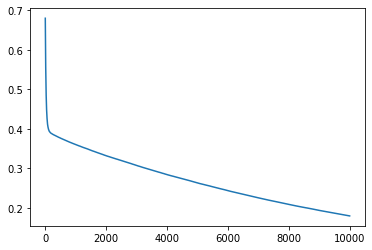

In [126]:
plt.plot(main_result[1]['learn']['MultiClass']) #32.Театр


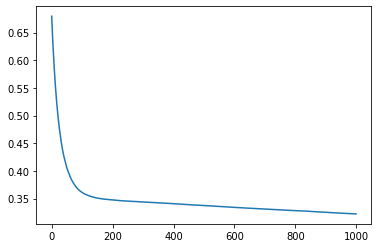

In [90]:
plt.plot(main_result[2]['learn']['MultiClass']) #33. Ночные клубы